In [230]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from API

In [231]:
import os
from dotenv import load_dotenv, find_dotenv

In [232]:
load_dotenv('./../controller/.env')


True

In [233]:
print(os.getenv("API_URL"))

https://zerofourtwo.new/api


In [234]:
# load dataset from api
headers = {"Authorization": f"Bearer {os.getenv('API_SECRET_KEY')}"}
df = pd.read_json(r'http://localhost:3000/api/dataset', storage_options=headers)

In [235]:
df.head()

#df = df.query("_user == 'intotito'")


,_id,_date,_user,fm_avg_trk_time,fm_accuracy,vx_avg_res_time,vx_shot_accuracy,vx_trg_accuracy,au_avg_res_time,bm_HR_max,bm_HR_avg,bm_HR_var,bm_act_steps,bm_sleep
0,1,None,jjj,9,40.0000,3.0,47.2222,62.9630,3255.0,NaN,59.0,71.0,NaN,4.0
1,2,2024-02-01T23:31:26.000Z,jjj,2,92.3077,2.0,58.0645,87.8049,2135.0,NaN,NaN,NaN,NaN,NaN
2,3,2024-02-02T23:52:30.000Z,jjj,2,92.3077,2.0,57.3770,70.0000,2018.0,NaN,60.0,61.0,NaN,4.0
3,4,2024-02-03T18:18:04.000Z,jjj,6,52.1739,3.0,47.6190,76.9231,2580.0,NaN,68.0,41.0,NaN,2.0
4,5,2024-02-02T13:10:54.000Z,jjj,8,52.1739,3.0,43.5897,80.9524,3495.0,220.0,NaN,NaN,NaN,NaN


# Clean Dataset

In [236]:
# delete unwanted columns
unwanted_columns = ['_id', '_date', '_user', 'bm_HR_max', 'bm_act_steps']
df_wanted = df.drop(unwanted_columns, axis=1)

In [237]:
# drop rows with missing values
df_wanted = df_wanted.dropna()
df_wanted.isna().sum()

fm_avg_trk_time     0
fm_accuracy         0
vx_avg_res_time     0
vx_shot_accuracy    0
vx_trg_accuracy     0
au_avg_res_time     0
bm_HR_avg           0
bm_HR_var           0
bm_sleep            0
dtype: int64

In [238]:
df_wanted.shape

(114, 9)

# Inspect data

In [239]:
df_wanted.head()

,fm_avg_trk_time,fm_accuracy,vx_avg_res_time,vx_shot_accuracy,vx_trg_accuracy,au_avg_res_time,bm_HR_avg,bm_HR_var,bm_sleep
0,9,40.0000,3.0,47.2222,62.9630,3255.0,59.0,71.0,4.0
2,2,92.3077,2.0,57.3770,70.0000,2018.0,60.0,61.0,4.0
3,6,52.1739,3.0,47.6190,76.9231,2580.0,68.0,41.0,2.0
5,5,80.0000,2.0,44.6809,87.5000,1850.0,66.0,33.0,0.0
6,2,92.3077,2.0,55.7377,85.0000,1689.0,65.0,36.0,4.0


In [240]:
df_wanted.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fm_avg_trk_time,114.0,2.368421,1.371409,1.0000,2.00000,2.00000,2.0000,9.0000
fm_accuracy,114.0,83.236346,13.073753,40.0000,75.00000,85.71430,92.3077,100.0000
vx_avg_res_time,114.0,1.947368,0.395598,1.0000,2.00000,2.00000,2.0000,3.0000
vx_shot_accuracy,114.0,56.610152,5.410179,44.4444,52.71325,57.37700,60.6061,70.1493
vx_trg_accuracy,114.0,85.984715,7.317262,62.9630,83.72090,87.22825,90.9091,97.9167
au_avg_res_time,114.0,2098.587719,455.088240,1122.0000,1813.25000,2017.00000,2348.0000,3255.0000
bm_HR_avg,114.0,69.500000,5.851027,59.0000,66.00000,69.00000,71.0000,88.0000
bm_HR_var,114.0,40.315789,11.537792,18.0000,35.00000,36.50000,42.0000,71.0000
bm_sleep,114.0,3.052632,1.578854,0.0000,2.00000,3.00000,4.0000,5.0000


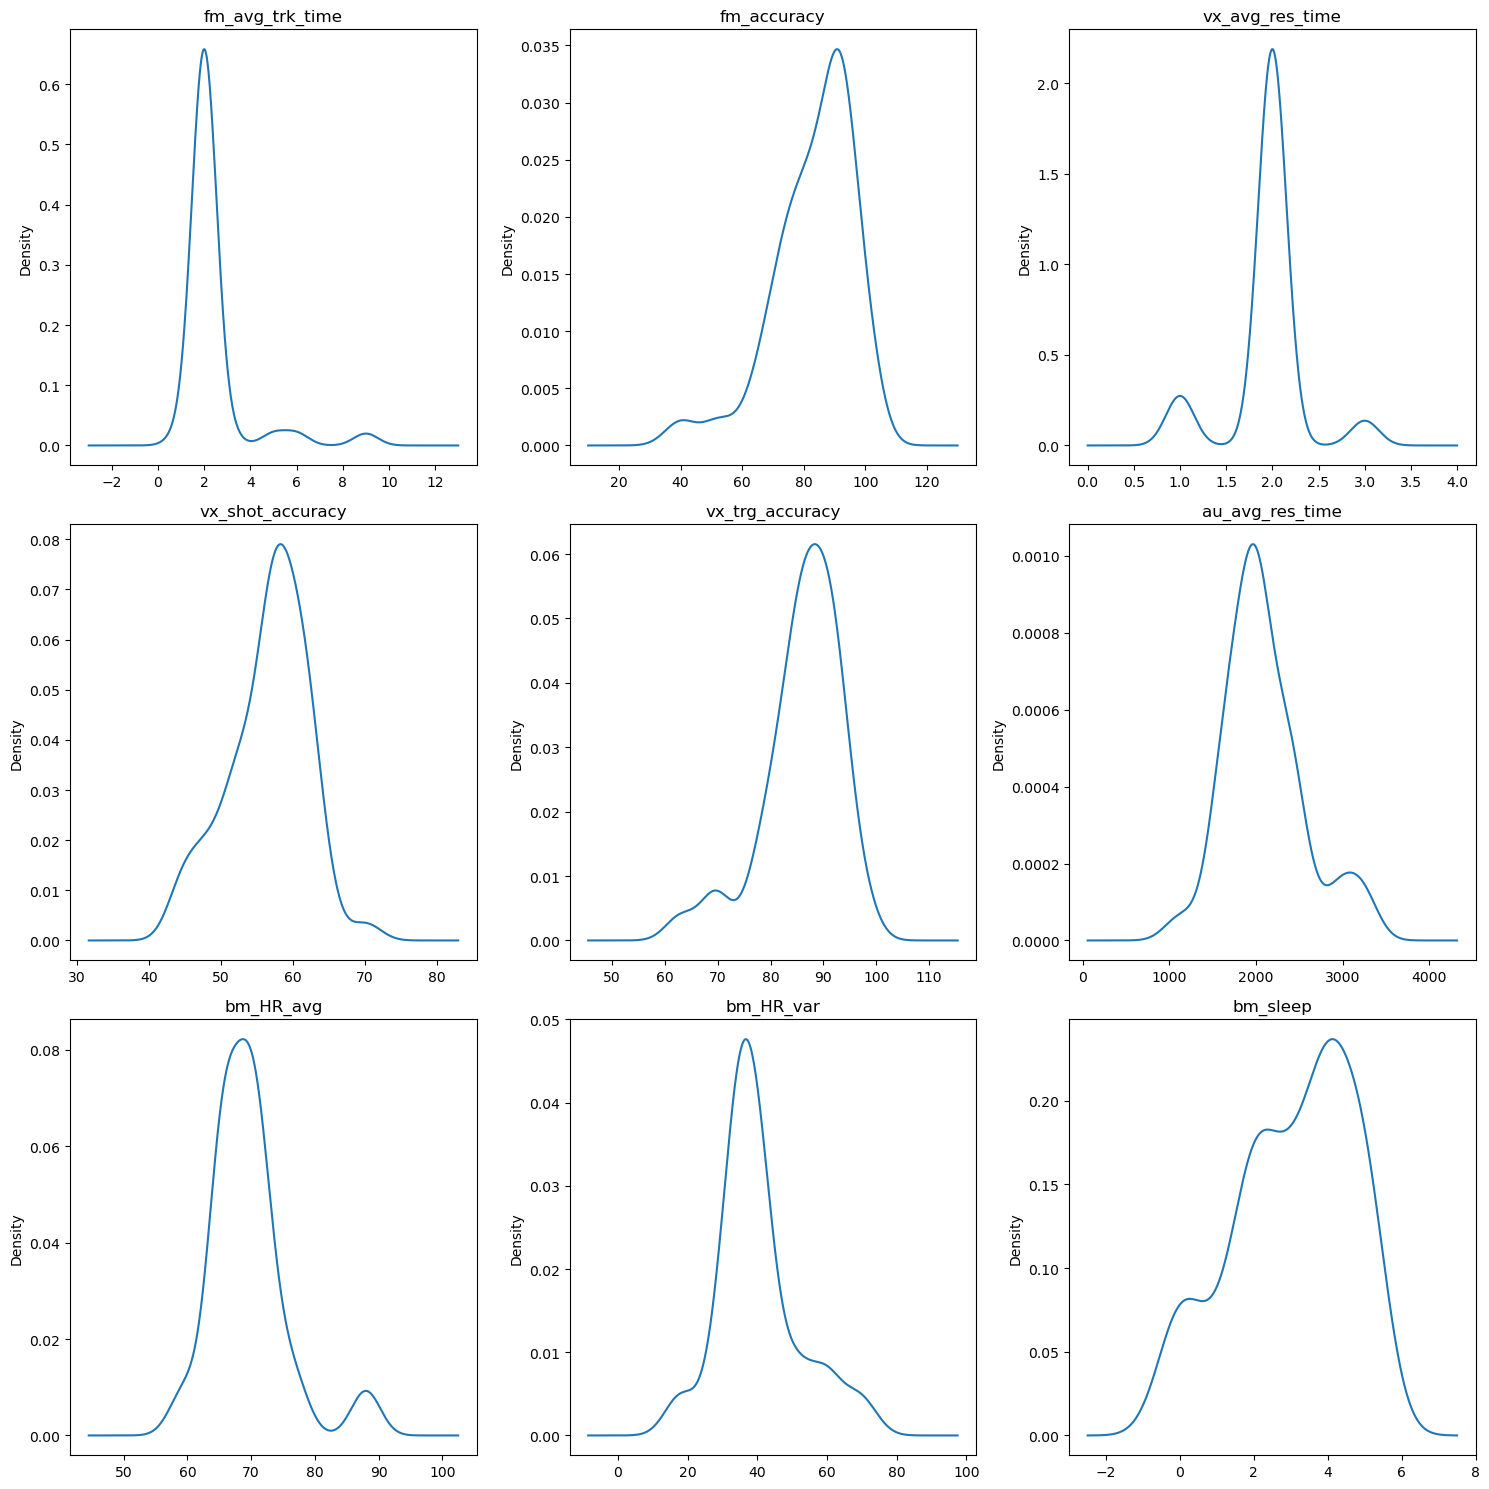

In [241]:
# plot normal distribution curve for each column using subplots
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, column in enumerate(df_wanted.columns):
    ax = plt.subplot(3, 3, i+1)
    df_wanted[column].plot(kind='kde', ax=ax)
    ax.set_title(column)
plt.tight_layout()
plt.show()



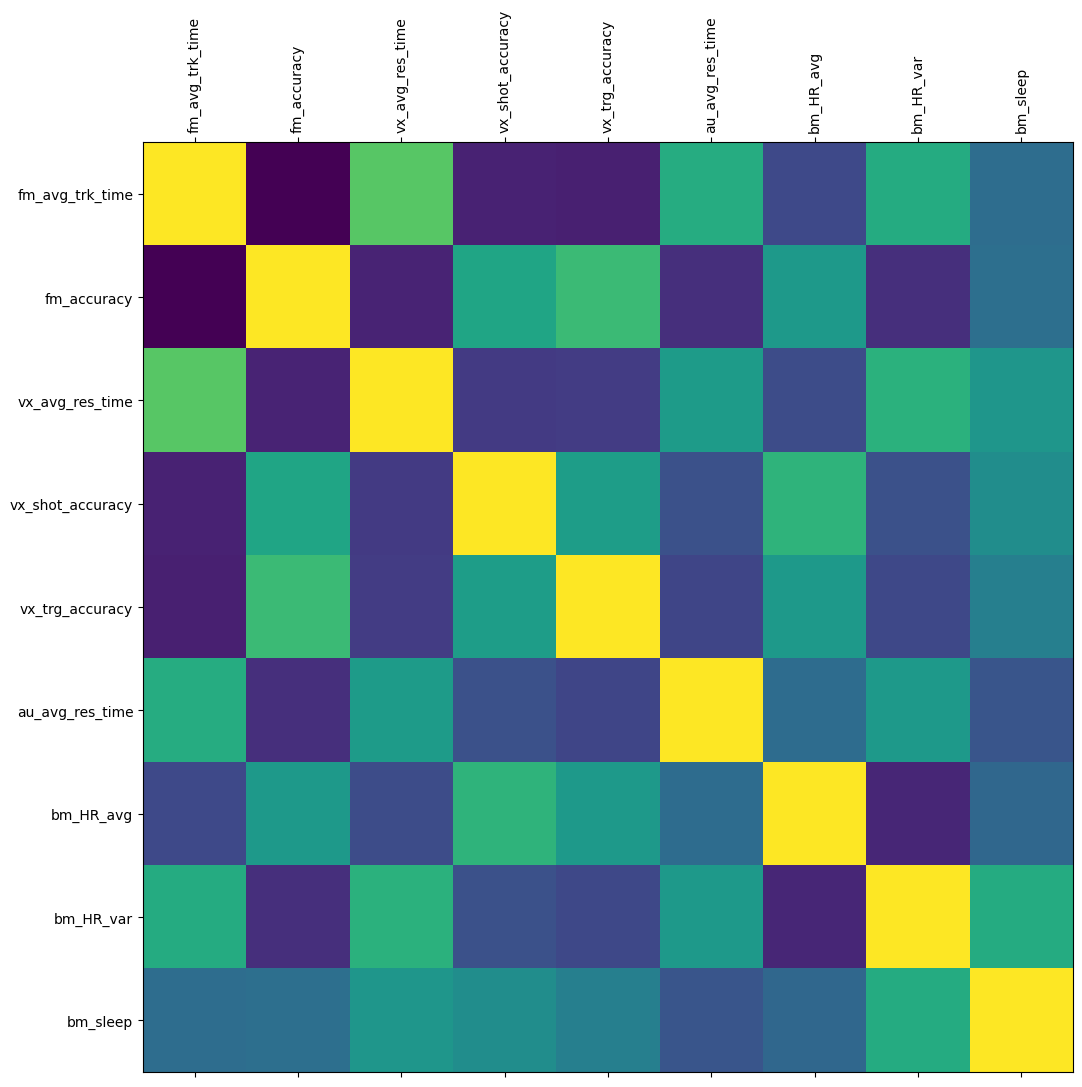

In [242]:
# show correlation matrix
correlation_matrix = df_wanted.corr()
plt.figure(figsize=(12, 12))
plt.matshow(correlation_matrix, fignum=1)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation='vertical')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
#plt.colorbar()
plt.show()



In [243]:
df_independent = df_wanted.iloc[:, -3:]
df_independent.shape

(114, 3)

In [244]:
df_dependent = df_wanted.iloc[:, :-3]
df_dependent.shape

(114, 6)

# Regression Model to predict vx_shot_accuracy using independent variables as input

In [245]:
# split dataset into training and testing
#from keras.models import LinearRegression
from sklearn.model_selection import train_test_split

X = df_independent
y = df_dependent

In [246]:
# scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)


In [247]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [248]:
# create linear regression model with 3 input and 6 output
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(3, input_dim=3, activation='tanh'))
model.add(tf.keras.layers.Dense(15, activation='tanh'))
model.add(tf.keras.layers.Dense(6, activation='tanh'))



In [249]:
# compile model
model.compile(optimizer='adam', loss='mean_squared_error')


In [250]:
# train model
model.fit(X_train, y_train, epochs=750, batch_size=10)



Epoch 1/750


10/10 [==============================] - 0s 2ms/step - loss: 1.0390
Epoch 2/750
10/10 [==============================] - 0s 1ms/step - loss: 1.0123
Epoch 3/750
10/10 [==============================] - 0s 1ms/step - loss: 0.9881
Epoch 4/750
10/10 [==============================] - 0s 1ms/step - loss: 0.9671
Epoch 5/750
10/10 [==============================] - 0s 2ms/step - loss: 0.9484
Epoch 6/750
10/10 [==============================] - 0s 1ms/step - loss: 0.9288
Epoch 7/750
10/10 [==============================] - 0s 1ms/step - loss: 0.9114
Epoch 8/750
10/10 [==============================] - 0s 1ms/step - loss: 0.8948
Epoch 9/750
10/10 [==============================] - 0s 1ms/step - loss: 0.8796
Epoch 10/750
10/10 [==============================] - 0s 1ms/step - loss: 0.8665
Epoch 11/750
10/10 [==============================] - 0s 1ms/step - loss: 0.8544
Epoch 12/750
10/10 [==============================] - 0s 1ms/step - loss: 0.8440
Epoch 13/750
10/10 [=============================

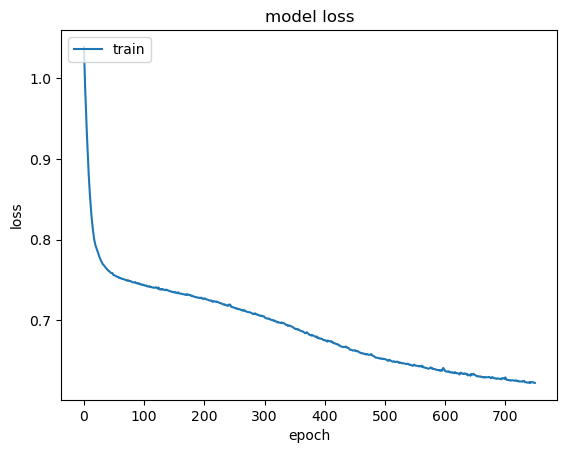

In [251]:
# plot training and validation loss
plt.plot(model.history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [252]:
# calculate r2 score
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)



1/1 [==============================] - 0s 49ms/step


0.22284127141706714

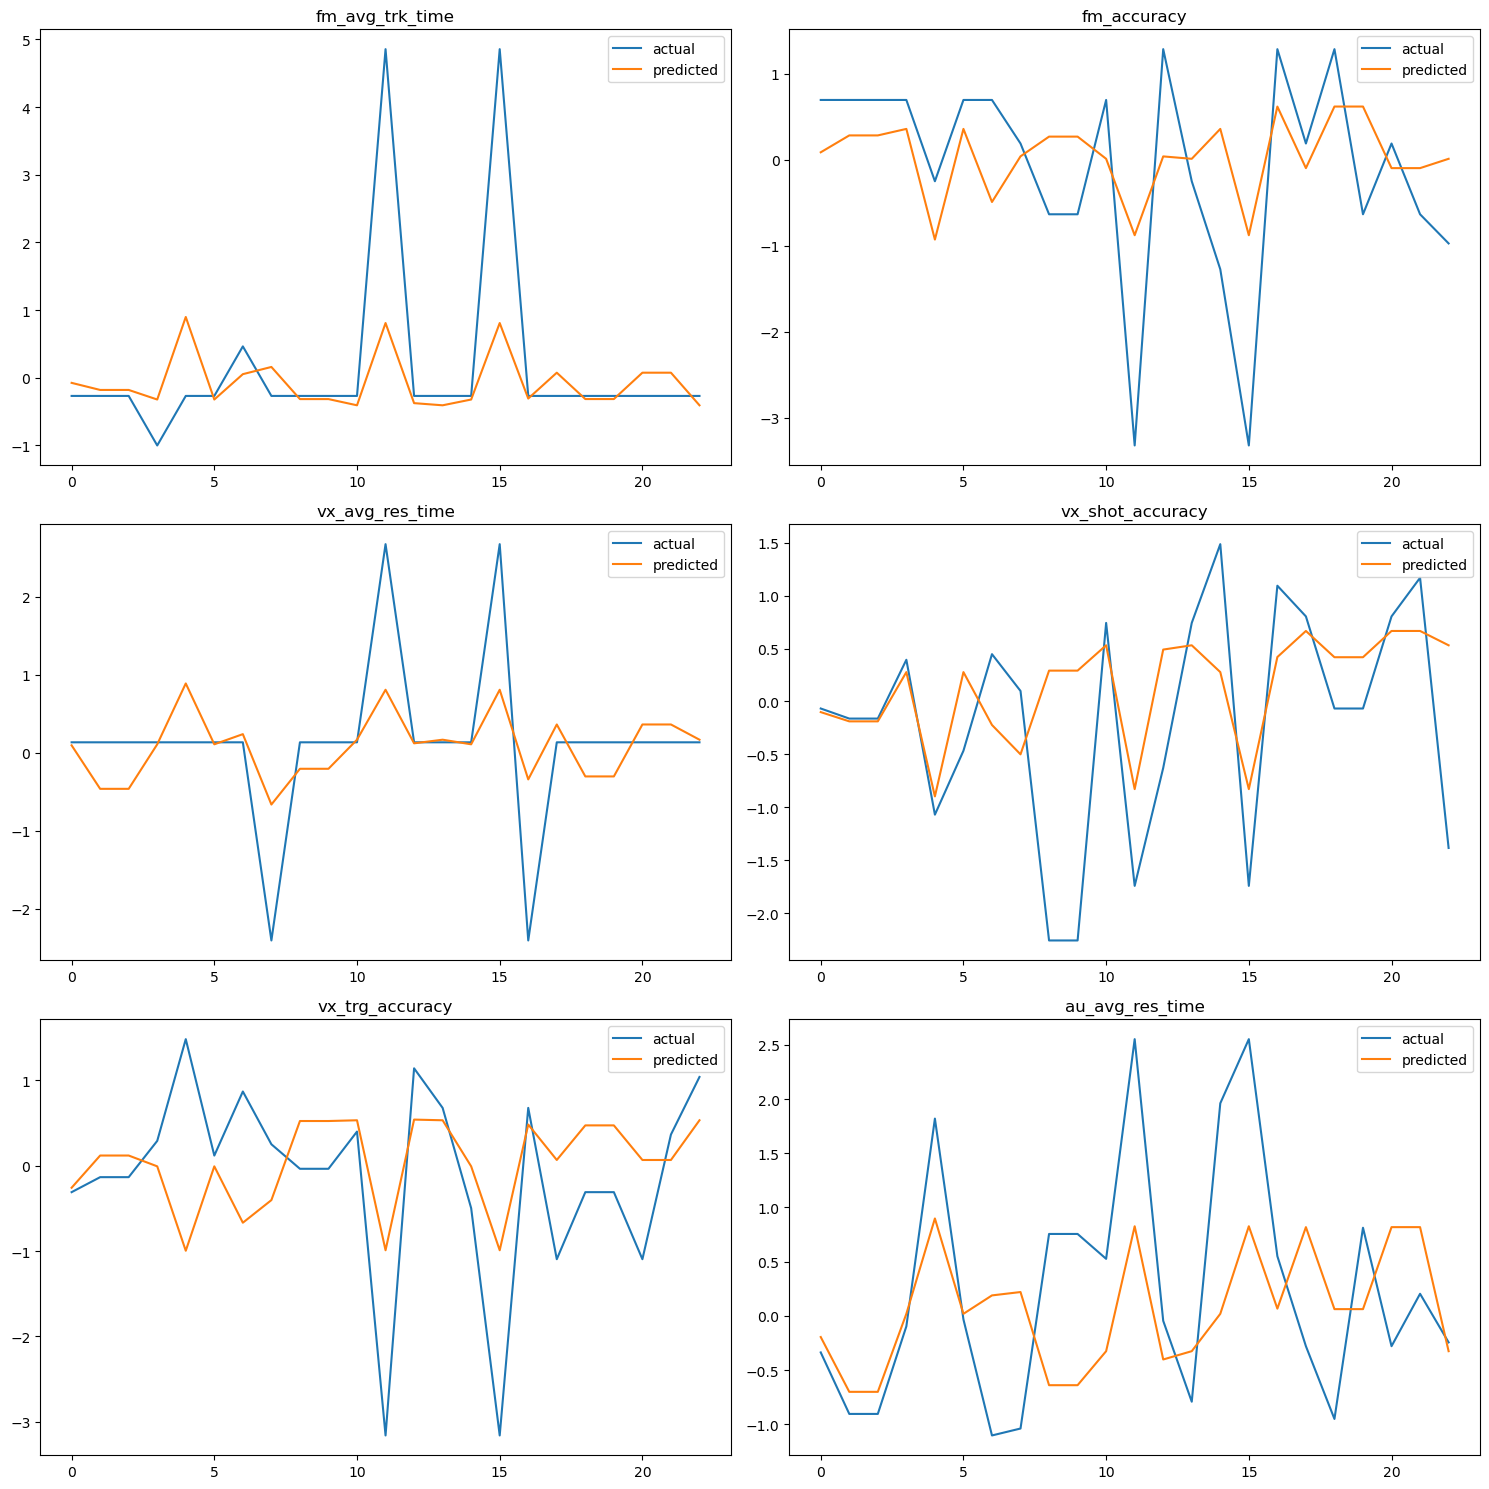

In [253]:
# plot actual vs predicted for each column
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for i, column in enumerate(df_dependent.columns):
    ax = plt.subplot(3, 2, i+1)
    ax.plot(y_test[:, i], label='actual')
    ax.plot(y_pred[:, i], label='predicted')
    ax.set_title(column)
    ax.legend()
plt.tight_layout()
plt.show()

In [254]:
# evaluate r2 score for the model
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)


0.22284127141706714